In [1]:
import time
from tqdm import tqdm

import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.ensemble import RandomForestClassifier

import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)

import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils
from keras.callbacks import EarlyStopping

2023-02-01 20:53:59.625926: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
data_path = "/home/sharedrive/ids_dataset/early_detection/data_vary_N/lstm_data/packet_6/n_5/"

### LSTM training with N=1 (Imbalance Data)

In [3]:
X_train, y_train = np.load(data_path+"X_train_n_5.npy", allow_pickle=True), np.load(data_path+"y_train_n_5.npy", allow_pickle=True)
X_test, y_test = np.load(data_path+"X_test_n_5.npy", allow_pickle=True), np.load(data_path+"y_test_n_5.npy", allow_pickle=True)

In [4]:
y_train_series = pd.Series(y_train, name="Label") 
y_test_series = pd.Series(y_test, name="Label") 

In [5]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [6]:
print("Test Size\n", y_test_series.value_counts())
print("Train Size\n", y_train_series.value_counts())

Test Size
 benign    1842
attack     138
Name: Label, dtype: int64
Train Size
 benign    4325
attack     279
Name: Label, dtype: int64


<AxesSubplot: >

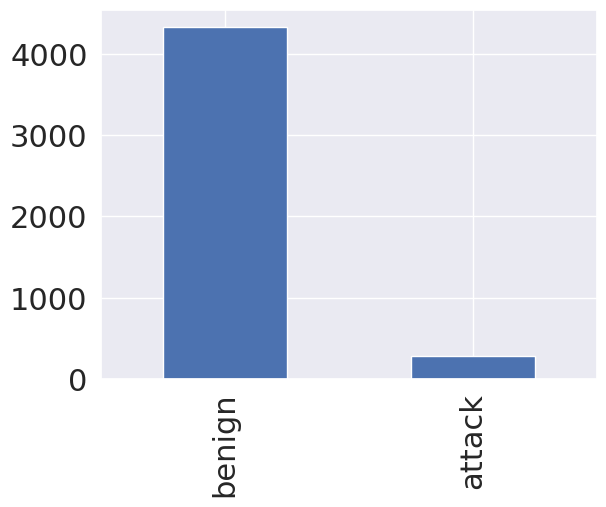

In [7]:
y_train_series.value_counts().plot(kind='bar')

In [8]:
# Label preparation for RandomForest
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [9]:
le.transform(["attack", "benign"])

array([0, 1])

In [10]:
def create_baseline():
    model = Sequential()
    
    model.add(Bidirectional(LSTM(64, activation='tanh', kernel_regularizer='l2')))
    model.add(Dense(128, activation = 'relu', kernel_regularizer='l2'))
    model.add(Dense(1, activation = 'sigmoid', kernel_regularizer='l2'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    return model

In [11]:
model = create_baseline()

2023-02-01 20:54:18.159359: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 20:54:18.239218: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 20:54:18.239520: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 20:54:18.240430: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

In [12]:
y_train_encoded = y_train_encoded.astype(float)
y_test_encoded = y_test_encoded.astype(float)

In [13]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=20)

In [14]:
history = model.fit(X_train, y_train_encoded, epochs = 40, validation_split=0.1, verbose = 1, callbacks=[es])

Epoch 1/40


2023-02-01 20:54:21.984534: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400
2023-02-01 20:54:22.173120: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


130/130 [==============================] - 4s 11ms/step - loss: 0.8003 - accuracy: 0.9913 - val_loss: 3.2583 - val_accuracy: 0.3970
Epoch 2/40
130/130 [==============================] - 1s 8ms/step - loss: 0.0555 - accuracy: 0.9998 - val_loss: 3.5974 - val_accuracy: 0.3970
Epoch 3/40
130/130 [==============================] - 1s 8ms/step - loss: 0.0206 - accuracy: 0.9998 - val_loss: 4.0786 - val_accuracy: 0.3970
Epoch 4/40
130/130 [==============================] - 1s 8ms/step - loss: 0.0168 - accuracy: 0.9998 - val_loss: 3.8071 - val_accuracy: 0.3970
Epoch 5/40
130/130 [==============================] - 1s 8ms/step - loss: 0.0152 - accuracy: 0.9998 - val_loss: 3.7376 - val_accuracy: 0.3970
Epoch 6/40
130/130 [==============================] - 1s 8ms/step - loss: 0.0147 - accuracy: 0.9998 - val_loss: 3.8807 - val_accuracy: 0.3970
Epoch 7/40
130/130 [==============================] - 1s 8ms/step - loss: 0.0144 - accuracy: 0.9998 - val_loss: 3.9155 - val_accuracy: 0.3970
Epoch 8/40
130/1

In [15]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 128)              38912     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 55,553
Trainable params: 55,553
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
# model.save('lstm_model_40_N_1.h5')

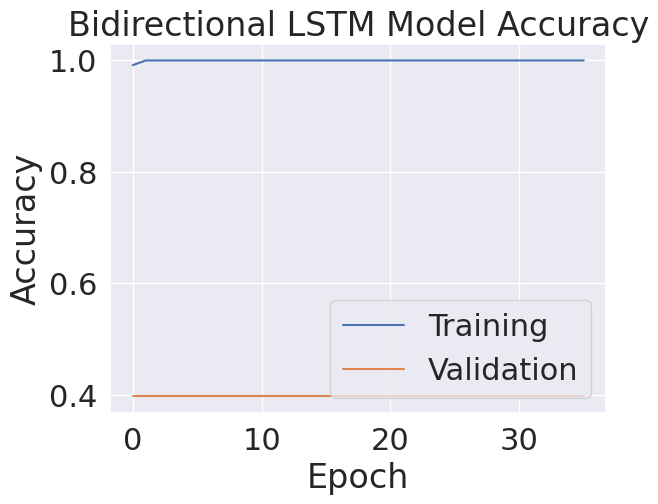

In [17]:
print(history)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Bidirectional LSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
# plt.savefig('Bidirectional LSTM Model Accuracy.png')
plt.show()

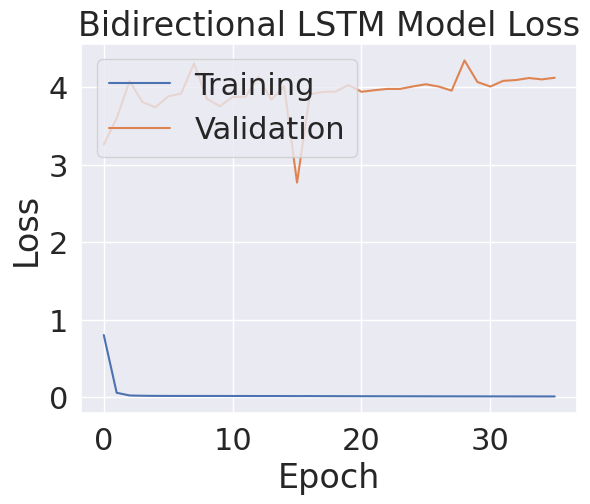

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Bidirectional LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
# plt.savefig('Bidirectional LSTM Model Loss.png')
plt.show()

In [19]:
X_test.shape

(1980, 5, 11)

In [25]:
1980/32

61.875

In [23]:
predictions = model.predict(X_test)

62/62 [==============================] - 0s 2ms/step


In [481]:
predictions = (predictions>0.5).astype(int)

Accuracy =  0.9303
Precision =  0.4652
Recall =  0.5
F1 =  0.4819
[[   0  138]
 [   0 1842]]


/home/mty754/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot: >

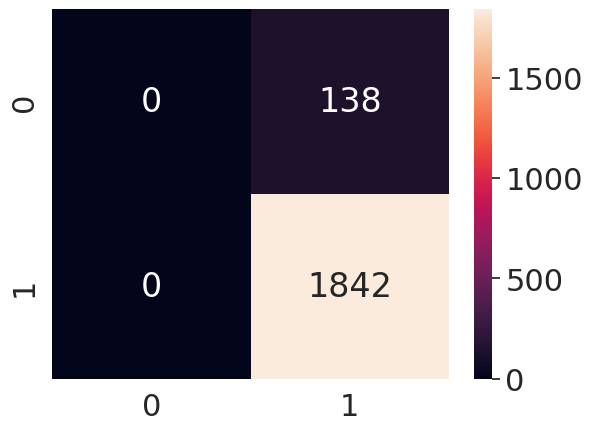

In [482]:
from sklearn import metrics
print("Accuracy = ", round(metrics.accuracy_score(y_test_encoded, predictions), 4))
print("Precision = ", round(metrics.precision_score(y_test_encoded, predictions, average='macro'), 4))
print("Recall = ", round(metrics.recall_score(y_test_encoded, predictions, average='macro'), 4))
print("F1 = ", round(metrics.f1_score(y_test_encoded, predictions, average='macro'), 4))
#Confusion Matrix - verify accuracy of each class
cm = confusion_matrix(y_test_encoded, predictions)
print(cm)
sns.heatmap(cm, annot=True, fmt='.10g')